# 1x1 Convolutions

- [Simple test setup](#Simple-test-setup)
- [Experimentation](#Experimentation)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import pickle
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'classifier/Plots_1x1/'
modelpath = path_prefix+'classifier/Models/'

# import our resolution utilities
import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

inputpath = path_prefix+'inputs/'
rootfiles = ["pi0", "piplus", "piminus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)

Using TensorFlow backend.


In [3]:
np0 = len(pdata['pi0'])
npp = len(pdata['piplus'])
npm = len(pdata['piminus'])

print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
print("Total: {}".format(np0+npp+npm))

pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False)
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

Number of pi0 events: 263891
Number of pi+ events: 435967
Number of pi- events: 434627
Total: 1134485


In [4]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras

import tensorflow as tf
from sklearn.metrics import roc_curve, auc

gpu_list = ["/gpu:0"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [5]:
training_classes = ['pi0','piplus']
# create train/validation/test subsets containing 70%/10%/20%
# of events from each type of pion event
pdata_merged, pcells_merged, plabels = mu.createTrainingDatasets(training_classes, pdata, pcells)

pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)
pcells_EMB2_channels = mu.setupChannelImages(mu.rescaleImages(pcells_merged, (16, 16)))

## Simple test setup
<div style="text-align: right"> <a href="#1x1-Convolutions">Top</a> </div>

In [6]:
filters = {
    'EMB1': (1,1), 
    'EMB2': (1,1), 
    'EMB3': (1,1), 
    'TileBar0': (1,1), 
    'TileBar1': (1,1), 
    'TileBar2': (1,1)
}
filters2 = {
    'EMB1': (4,8), 
    'EMB2': (8,8), 
    'EMB3': (4,2), 
    'TileBar0': (2,2), 
    'TileBar1': (2,2), 
    'TileBar2': (1,1)
}
pools2 = {
    'EMB1': (2,2), 
    'EMB2': (2,2), 
    'EMB3': (1,1), 
    'TileBar0': (1,1), 
    'TileBar1': (1,1), 
    'TileBar2': (1,1)
}

In [7]:
def cnn_model_1x1():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [8]:
model = cnn_model_1x1()


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [9]:
history = model.fit(pcells_EMB2_channels[pdata_merged.train],
                    plabels[pdata_merged.train], 
                    validation_data=(pcells_EMB2_channels[pdata_merged.val], plabels[pdata_merged.val]),
                    epochs=100, batch_size=200*ngpu, verbose=2)
history = history.history

Train on 489899 samples, validate on 69988 samples
Epoch 1/100
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
489899/489899 - 21s - loss: 0.3052 - acc: 0.8686 - val_loss: 0.2422 - val_acc: 0.9031
Epoch 2/100

Epoch 75/100
489899/489899 - 13s - loss: 0.1873 - acc: 0.9261 - val_loss: 0.1907 - val_acc: 0.9270
Epoch 76/100
489899/489899 - 13s - loss: 0.1869 - acc: 0.9262 - val_loss: 0.1878 - val_acc: 0.9275
Epoch 77/100
489899/489899 - 13s - loss: 0.1866 - acc: 0.9266 - val_loss: 0.1884 - val_acc: 0.9275
Epoch 78/100
489899/489899 - 13s - loss: 0.1863 - acc: 0.9269 - val_loss: 0.1884 - val_acc: 0.9272
Epoch 79/100
489899/489899 - 13s - loss: 0.1867 - acc: 0.9264 - val_loss: 0.1878 - val_acc: 0.9265
Epoch 80/100
489899/489899 - 13s - loss: 0.1866 - acc: 0.9263 - val_loss: 0.1892 - val_acc: 0.9261
Epoch 81/100
489899/489899 - 13s - loss: 0.1860 - acc: 0.9263 - val_loss: 0.1899 - val_acc: 0.9268
Epoch 82/100
489899/489899 - 13s - loss: 0.1862 - acc: 0.9266 - val_loss: 0.1898 - val_acc: 0.9268
Epoch 83/100
489899/489899 - 13s - loss: 0.1862 - acc: 0.9266 - val_loss: 0.1888 - val_acc: 0.9278
Epoch 84/100
489899/489899 - 13s - loss: 0.1856 - acc: 0.9265 - val_loss: 0.1867 - val_acc: 0.9276
Epoch 85/1

In [10]:
# save network

model.save(modelpath+"model_cnn_1x1.h5")
with open(modelpath + "model_cnn_1x1.history",'wb') as model_history_file:
    pickle.dump(history, model_history_file)

In [8]:
# load network

model = tf.keras.models.load_model(modelpath+"model_cnn_1x1.h5")
with open(modelpath + 'model_cnn_1x1.history','rb') as model_history_file:
    history = pickle.load(model_history_file)

In [12]:
# get overall performance metric
performance = model.evaluate(
    pcells_EMB2_channels[pdata_merged.test], plabels[pdata_merged.test],
    verbose = 0,
)

# get network scores for the dataset
score = model.predict(
    pcells_EMB2_channels
)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


<Figure size 576x432 with 0 Axes>

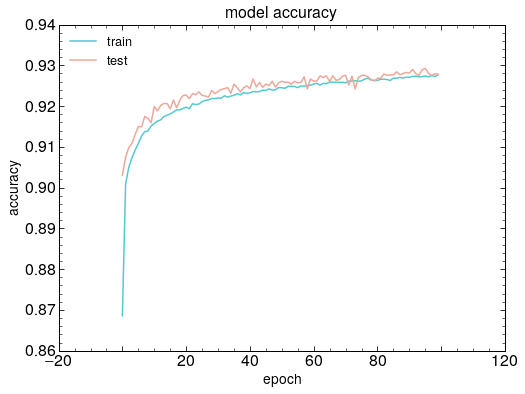

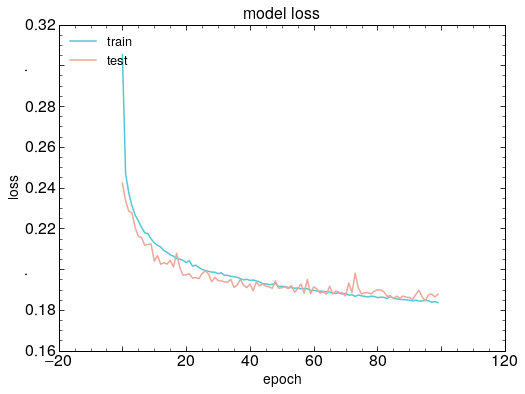

In [16]:

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plotpath + 'test_acc.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(plotpath + 'test_loss.pdf')
plt.show()

In [19]:
from sklearn.metrics import roc_curve, auc

roc_fpr, roc_tpr, roc_thresh = roc_curve(
    plabels[pdata_merged.test][:,1],
    score[pdata_merged.test,1],
    drop_intermediate=False,
)
roc_auc = auc(roc_fpr, roc_tpr)
print('Area under curve: ' + str(roc_auc))

Area under curve: 0.9773601106216215


<Figure size 576x432 with 0 Axes>

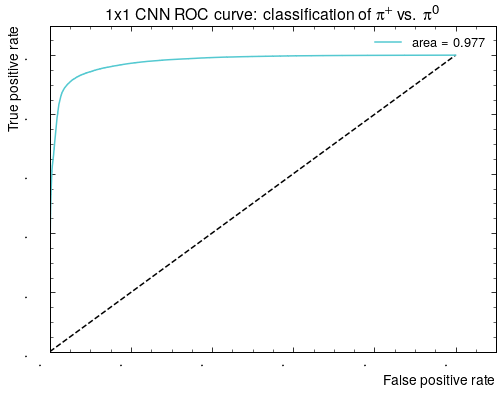

In [21]:
pu.roc_plot([roc_fpr], [roc_tpr],
            figfile=plotpath + 'roc_cnn_1x1.pdf',
            labels=['area = {:.3f}'.format(roc_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title='1x1 CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')

## Experimentation
<div style="text-align: right"> <a href="#1x1-Convolutions">Top</a> </div>

In [24]:
def test_model(model,filename='',
               epochs=100):
    '''
    Convenience function for training and calculating
    the area-under-curve for a model
    '''
    
    # train model
    f_history = model.fit(pcells_EMB2_channels[pdata_merged.train],
                        plabels[pdata_merged.train], 
                        validation_data=(pcells_EMB2_channels[pdata_merged.val], plabels[pdata_merged.val]),
                        epochs=100, batch_size=200*ngpu, verbose=2)
    f_history = f_history.history
    
    # save trained weights and history
    if(filename != ''):
        model.save(modelpath+filename+".h5")
        with open(modelpath+filename +".history",'wb') as model_history_file:
            pickle.dump(f_history, model_history_file)
            
    # get network scores for the dataset
    f_score = model.predict(
        pcells_EMB2_channels
    )
    
    # calculate roc and auc
    f_roc_fpr, f_roc_tpr, f_roc_thresh = roc_curve(
        plabels[pdata_merged.test][:,1],
        f_score[pdata_merged.test,1],
        drop_intermediate=False,
    )
    f_roc_auc = auc(f_roc_fpr, f_roc_tpr)
    
    pu.roc_plot([f_roc_fpr], [f_roc_tpr],
            figfile=plotpath+filename+'_roc.pdf',
            labels=['area = {:.3f}'.format(f_roc_auc)],
            extra_lines=[[[0, 1], [0, 1]]],
            title=filename+' ROC curve: classification of $\pi^+$ vs. $\pi^0$')
    return f_roc_auc

In [25]:
# models to test
def cnn_model_1x1_no_maxpool():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
#         x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model
    
def cnn_model_1x1_no_dropout():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x = Convolution2D(32, (1, 1), activation='relu', data_format = 'channels_first')(input1)
        x = MaxPool2D(pool_size=(2, 2))(x)
#         x = Dropout(0.2)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu')(x)
        x = Dense(64, activation='relu')(x)
        output = Dense(2, activation='softmax')(x)
        model = Model(inputs = [input1], outputs = [output])
        
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [ ]:
# test models
models = [cnn_model_1x1_no_maxpool(),cnn_model_1x1_no_dropout()]
fnames = ['no_maxpool','no_dropout']


for m,n in zip(models,fnames):
    res = test_model(m,filename=n)
    print(n, res)